In [1]:
%matplotlib inline

# General Flow of Events

- (1) Load data
- (2) Center and Scale data
- (3) Cluster
- (4) Feature Selection (k-best)
- (5) Feature Extraction (PCA)
- (6) Feature Unionize
- (7) Training and Cross-Validation
- (8) Testing


In [22]:
# high-level imports
import numpy as np
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn import datasets, decomposition, preprocessing
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import random

# local imports
import plot_helpers as helpers

print('Imports complete.')

Imports complete.


In [64]:
# (1) Load Data
# dataset = datasets.load_iris()
dataset = datasets.load_digits()
X, y = dataset.data, dataset.target
n_samples, n_features = X.shape
print(X.shape)


(1797, 64)


In [24]:
# (2) Center and Scale Data (if deemed necessary)
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [ ]:
# (3) Cluster
# TODO choose K according to truncated PCA, see: http://ranger.uta.edu/~chqding/papers/KmeansPCA1.pdf


In [ ]:
# (4) Feature Selection (k- best)
selection = SelectKBest(k=1)

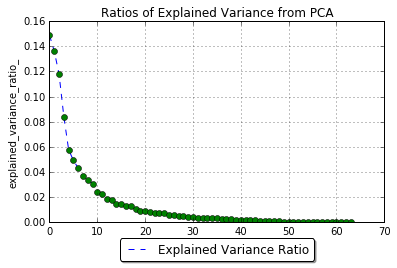

Done


In [35]:
# (5) Feature Extraction (PCA)
#TODO choose appropriate dimensionality reduction, see: http://scikit-learn.org/stable/auto_examples/plot_compare_reduction.html#sphx-glr-auto-examples-plot-compare-reduction-py

# reduce the dimensionality of the data with PCA
pca = decomposition.PCA()
pca.fit(X)

# plot the data
plt.hold(True)
plt.plot(pca.explained_variance_ratio_, '--')
plt.plot(pca.explained_variance_ratio_, 'o', linewidth=2)

# plot properties
ax = plt.subplot(111)
helpers.external_legend(ax, ['Explained Variance Ratio'])
helpers.plot_format('Ratios of Explained Variance from PCA', 'n_components', 'explained_variance_ratio_')
plt.show()

print('Done')

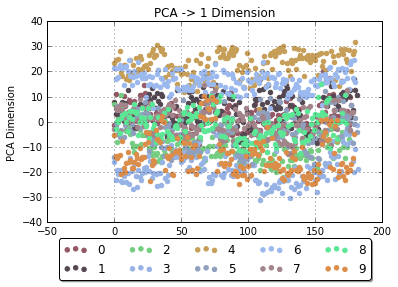

In [36]:
X1 = decomposition.PCA(n_components=1).fit(X).transform(X)
colors = helpers.random_colors(len(dataset.target_names))
names = dataset.target_names

# plot the dimension-reduced data
ax = plt.subplot(111)
plt.hold(True)
for name, label in zip(names, range(len(names))):
    points = X1[y == label]
    plt.scatter(range(len(points)), points, color=colors[label], marker='o')

# plot properties
helpers.external_legend(ax, names)
helpers.plot_format('PCA -> 1 Dimension', 'Index', 'PCA Dimension')
plt.show()


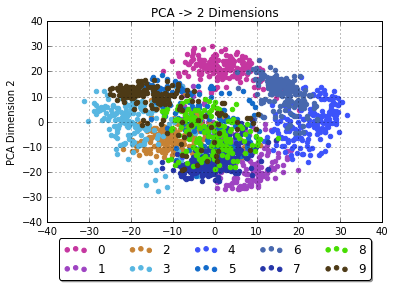

In [37]:
X2 = decomposition.PCA(n_components=2).fit(X).transform(X)
colors = helpers.random_colors(len(dataset.target_names))
names = dataset.target_names

# plot the dimension-reduced data
ax = plt.subplot(111)
plt.hold(True)
for name, label in zip(names, range(len(names))):
    points = X2[y == label]
    plt.scatter(points[:,0], points[:,1], color=colors[label], marker='o')

# plot properties
helpers.external_legend(ax, names)
helpers.plot_format('PCA -> 2 Dimensions', 'PCA Dimension 1', 'PCA Dimension 2')
plt.show()


In [87]:
# split the data into training, cross-validation, and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


dim_red_func = decomposition.PCA
clf_func = SVC

In [88]:
# (7) Training and Cross-Validation

# specify the grid over which to perform the exhaustive grid search

# start with 1:10. if we have more than 10 features, append 10 evenly spaced integers in [11, n_features]
pca_n_components = np.arange(1, 11)
if n_features > 10:
    pca_n_components = np.append(pca_n_components, np.linspace(11, n_features, num=5, dtype=np.int))
    
grid = [
    {
        'pca__n_components': pca_n_components,
        'svm__kernel': ['rbf'],
        'svm__gamma': [1e-3, 1e-4],
        'svm__C': [1, 10, 100, 1000]
    },
    {
        'pca__n_components': pca_n_components,
        'svm__kernel': ['linear'],
        'svm__gamma': [1e-3, 1e-4],
        'svm__C': [1, 10, 100, 1000]
    }
]

# create the pipeline
pipeline = Pipeline(steps=[('pca', dim_red_func()), ('svm', clf_func())])

# specify scoring metrics to use in determining "best" classifiers
scores = ['precision', 'recall']


In [89]:
# process the pipelne to find the "best" classifier(s)
# store the "best" classfiers, according to each scoring metric
clf_candidates = [None] * len(scores)

# TODO randomized search
# TODO smarted search in the space
# perform the search over the grid
for i, score in enumerate(scores):
    # find the best classifier in the given grid, according to the current scoring metric
    clf = GridSearchCV(estimator=pipeline,
                       param_grid=grid,
                       cv=5,  # k-fold CV
                       )
    clf.fit(X_train, y_train)
    clf_candidates[i] = clf

    print("Best parameter set found in grid: \n\t{}".format(clf.best_params_))
    print("\tScore: {}".format(clf.best_score_))
    print("\tMetric: {}".format(score))

KeyboardInterrupt: 

In [63]:
# (8) Testing
for i, clf in enumerate(clf_candidates):
    y_pred = clf.predict(X_test)
    print("Score for best{} clf: {}".format(scores[i], np.mean(y_pred == y_test)))

Score for bestprecision clf: 0.9907407407407407
Score for bestrecall clf: 0.9907407407407407


In [ ]:
# Evaluation
# confusion matrix
# ROC curve